In [153]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 7)

coffee = pd.read_csv('data/coffee.csv', index_col=0)

true = pd.read_csv('data/missing_true.csv')
unif = pd.read_csv('data/missing_unif.csv')
depd = pd.read_csv('data/missing_depd.csv')

def plot_distributions(**kwargs):
    '''plot two series/'''
    L = [v.assign(missing=k) for (k, v) in kwargs.items()]
    title = 'distribution of value'
    G = pd.concat(L).groupby('missing')['value']
    return G.plot(kind='kde', legend=True, title=title)

# Handling Missing Data
---

Determining the nature of missing data naturally leads to the question of *what to do with the missing data*. The possibilities for handling missing data are influenced by 
* the kind of data being considered,
* the mechanism of missingness identified in the generation of the data,
* the type of model being fit on the data (and what it's used for).

Generally, techniques for handling missing data fall into three categories: 
1. working with the NULL values directly, as values themselves,
1. ignoring NULL values by 'dropping them' from the dataset,
1. imputing, or filling in, NULL values with their likely true value.

These techniques are not always clearly divided; use a combination of the above is often useful when dealing with multiple columns of a dataset. Understanding the strengths of each is an important piece of successfully cleaning a dataset for both descriptive and modeling tasks.

## Null values as values themselves

Working with NULL values directly has the advantage of being straightforward and transparent.

### Categorical Attributes

When an attribute is categorical, a NULL value can be represented as a category in its own right. If the attribute is stored as string values, then `NaN` can simply be represented by the string value `'NULL'` and considered a value like any other.

**Example:** A Data Scientist sat a local coffee shop and recorded the orders she observed (drink type, drink size, and tip amount). There are missing values in the dataset, due to a combination of factors, including noise and foot-traffic that made it hard to observe each transaction carefully. This dataset is saved in the dataframe `coffee`.

To compute the empirical distribution of coffee types, including `NaN` as a value itself, one must pass `dropna=False` to the `value_counts` method:

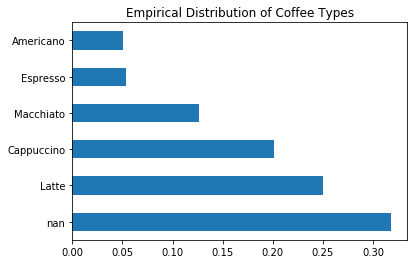

In [123]:
title = 'Empirical Distribution of Coffee Types'
coffee['Coffee'].value_counts(normalize=True, dropna=False).plot(kind='barh', title=title);

While this plot clearly shows that over 30% of the attribute is missing, it hides the fact that the 'nan' value is actually composed of the other values in the distribution. For example, if the 'nan' value is made up entirely of 'Espresso' drinks, the this distribution is very misleading!

Certain predictive models handle missing values represented this way very well; certain model implicitly learn mechanism of missingness (i.e. the disibtribution of true values behind the missing values) through correlations in the dataset. Of course, the effectiveness of this still depends on the missing data being *ignorable*.

### Missing Indicator Variables

The missingness of a column may be represented by an additional column that merely *indicates* if a particular value is missing from the dataset. Such a column is called a *missing indicator variable*.

**Example:** In the coffee shop data, indicator variables for the given columns are new columns that denote whether a given value is missing:

In [124]:
coffee.assign(
    Coffee_ismissing=coffee['Coffee'].isnull(),
    Size_ismissing=coffee['Size'].isnull(),
    Tip_ismissing=coffee['Tip'].isnull()
)

,Coffee,Size,Tip,Coffee_ismissing,Size_ismissing,Tip_ismissing
0,NaN,Sm,2.45,True,False,False
1,Macchiato,Sm,0.40,False,False,False
2,Cappuccino,Sm,NaN,False,False,True
...,...,...,...,...,...,...
997,Cappuccino,Md,NaN,False,False,True
998,Espresso,Lg,1.94,False,False,False
999,Cappuccino,Md,0.60,False,False,False


While this method has the advantage of only adding information to the dataset, it requires an additional step to remove the missing values in numeric data. However, this 'correctness' of the removal of the missing data is less important when doing multivariate analyses, due to its correlation with missing-indicator column.

## Dropping Missing Data

### List-wise Deletion

The most straight-forward way to deal with missing data is to just drop those observations with missing values. However, this method is riddled with issues:

* Dropping an observation with even a single missing value loses too much information. In the extreme case, a dataset with a single empty column would cause every observation to be dropped. It's better to only drop values when absolutely needed.
* In all cases but MCAR data, dropping missing observations will bias the data. When the likelihood an attribute is missing depends on another column, dropping missing observations will disproportionately affect the associated values in that column.

**Example:** In the coffee dataset, individually, each attribute has no more than 31.8% of the values missing. However, after list-wise deletion, the resulting dataset only contains 47.1% of the original observations -- this method loses over half the data!

In [125]:
coffee.isnull().mean().rename('Proportion Missing').to_frame()

,Proportion Missing
Coffee,0.318
Size,0.158
Tip,0.205


The proportion of the dataset remaining after list-wise deletion:

In [126]:
coffee.dropna().shape[0] / coffee.shape[0]

0.471

### Pairwise Deletion

Pairwise deletion drops only those observations with missing values that affect the computation being performed. While this fixes the issue of dropping too many observations, it still suffers from bias. This method also has strange side-effects due to the fact that different statistics may be calculated using a different number of observations.

**Example:** While list-wise deletion drops over half of the observations in `coffee` dataset, pairwise deletion drops much fewer. For example computing the mean tip involves only dropping those observations for which the tip is missing (20.5%).

*Remark:* The term 'pairwise deletion' comes from calculating correlation coefficients. To calculate the correlation matrix for a dataset, using pairwise deletion, loop through *pairs* of columns $(c_1, c_2)$:
1. drop missing values in the columns $c_1$ and $c_2$,
1. calculate the correlation coefficient between the two columns

Thus, each correlation coefficient is computed with the *maximal amount of data*.


### Dropping observations: an illustration

This example will use a table of synthetically generated data to understand imputation:
* The true population is defined in the DataFrame `true`, 
* `unif` is created from `true` by unconditionally erasing observations (MCAR), 
* `depd` is created from `true` by erasing observations dependent on `label`.

The DataFrames have two columns, 'label' and 'value'. Below is a summary of the true population:

In [140]:
true

,label,value
0,C,-0.472871
1,B,1.725308
2,C,-0.838320
...,...,...
997,C,-0.584425
998,B,1.679058
999,B,1.373065


In [144]:
true['label'].value_counts(normalize=True).sort_index().rename('Distribution of Labels').to_frame()

,Distribution of Labels
A,0.113
B,0.397
C,0.490


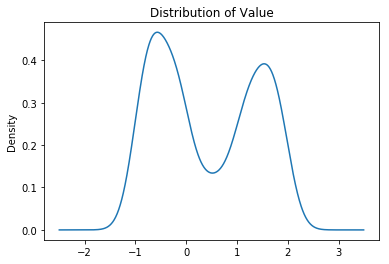

In [145]:
true['value'].plot(kind='kde', title='Distribution of Value');

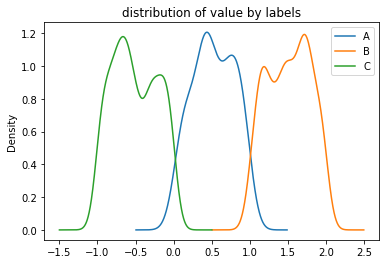

In [148]:
true.groupby('label')['value'].plot(kind='kde', legend=True, title='distribution of value by labels');

**Example:** The dataset `unif` simulates the observed data as being unconditionally missing (MCAR). The plot below compares these two distributions:

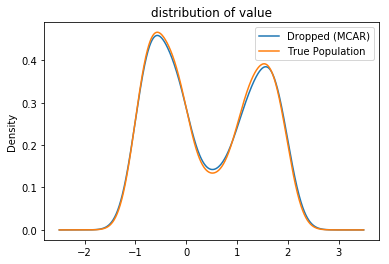

In [168]:
plot_distributions(**{'True Population': true, 'Dropped (MCAR)': unif});

The distributions look near identical, because the observed data is uniformly sampled from the true population. This is a verification that MCAR data look like a representative sample!

**Example:** The dataset `depd` simulates the observed data as being conditionally missing (MAR) dependent on the value of `label`. As the 'value' column varies with 'label', dropping the missing observations heavily biases the data.

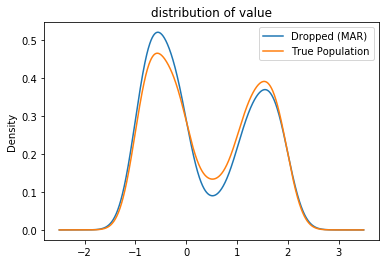

In [169]:
plot_distributions(**{'True Population': true, 'Dropped (MAR)': depd});

Comparing the two distributions shows that the values in the observed distribution skews toward smaller values. Computing the mean by dropping the observations in `depd` yields a downward bias:

In [173]:
print(
    'true mean: %f' %true['value'].mean(),
    'dropped mean: %f' % depd['value'].mean(),
    sep='\n'
)

true mean: 0.407980
dropped mean: 0.335408
